In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


No vtk


In [2]:
stack_fixed = 'MD642'
stack_moving = 'atlasV2'

In [3]:
classifier_setting = 2
warp_setting = 1

In [4]:
if warp_setting == 1:
    upstream_warp_setting = None
    transform_type = 'affine'
elif warp_setting == 2:
    upstream_warp_setting = 1
    transform_type = 'rigid'
else:
    raise Exception('Warp setting not recognized.')

In [5]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

print volume_moving[1].shape

(344, 418, 373)


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.


In [6]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)

print volume_fixed[1].shape

(487, 897, 387)


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_2/score_volumes/MD642_down32_scoreVolume_clf_2_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_2/score_volumes/MD642_down32_scoreVolume_clf_2_sp5.bp
Score volume for sp5 does not exist.


In [7]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}
#                     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [8]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [9]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [10]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [11]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [12]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

In [13]:
gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(\
                            stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                            downscale=32, classifier_setting=classifier_setting)
                           for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [14]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


load gradient 1: 5.370811 seconds
load gradient 2: 5.433557 seconds
load gradient 3: 5.494721 seconds
load gradient 4: 5.533272 seconds
load gradient 5: 5.518442 seconds
load gradient 6: 5.078528 seconds
load gradient 7: 5.600928 seconds
load gradient 8: 6.259254 seconds
load gradient 9: 5.299168 seconds
load gradient 10: 5.737577 seconds
load gradient 11: 6.361954 seconds
load gradient 12: 6.337992 seconds
load gradient 13: 5.819107 seconds
load gradient 14: 5.640958 seconds
load gradient 15: 6.493856 seconds
load gradient 16: 5.782841 seconds
load gradient 17: 6.271435 seconds
load gradient 18: 5.855417 seconds
load gradient 19: 6.350250 seconds
load gradient 20: 6.502966 seconds
load gradient 21: 5.886642 seconds
load gradient 22: 5.717786 seconds
load gradient 23: 5.616491 seconds
load gradient 24: 5.675707 seconds
load gradient 25: 5.218669 seconds
load gradient 26: 7.568102 seconds
load gradient 27: 14.064758 seconds
load gradient 28: 39.097134 seconds
overall: 205.592777 seconds

In [15]:
aligner.set_label_weights(label_weights=label_weights_m)

In [17]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:
for _ in range(1):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
                                     indices_m=None,
                                    grid_search_iteration_number=30,
                                     grid_search_sample_number=100,
                                     grad_computation_sample_number=1e5,
                                     lr1=10, lr2=0.1,
                                    std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))
        
        break
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


[Errno 12] Cannot allocate memory


[[  9.64145974e-01   4.17902932e-01   1.52698484e-01  -7.29906224e+01]
 [ -2.23489451e-01   1.00386496e+00   1.09127826e-01  -1.14316385e+01]
 [  8.10744785e-02  -5.76604923e-02   8.63141340e-01   2.58735821e+01]]
2.24160306682 2.24057817054


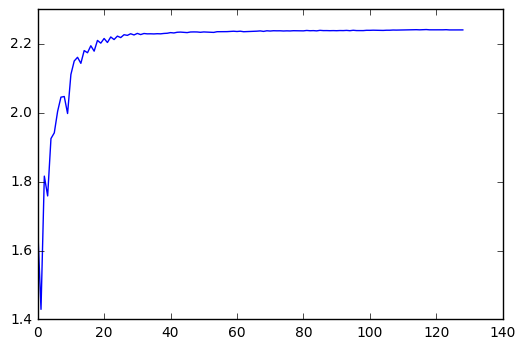

In [17]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

# Export parameters and score plots

In [ ]:
params_fp = \
DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                              classifier_setting_m=classifier_setting,
                                              classifier_setting_f=classifier_setting,
                                              warp_setting=warp_setting,
                                              trial_idx=0)

DataManager.save_alignment_parameters(params_fp, T, 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

score_plot_fp = \
DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting,
                                                     classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     trial_idx=0)
fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)